<a href="https://colab.research.google.com/github/phamvanhoangphi13112002/SuperstoreSalesAnalysis/blob/main/Returned_Good_Predictive_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Set up**

In [ ]:
!pip install xgboost
!pip install imbalanced-learn
!pip install category_encoders

## **Import necessary libraries**

In [ ]:
#import platform
import pandas as pd
import sklearn
import numpy as np
#import graphviz
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go

%matplotlib inline

## **Connect to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Read Files**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/PROJECTS/Project: SuperstoreSales/global_superstore_clean.csv')
data.shape

(51290, 24)

## **EDA Data**

In [ ]:
data.head()

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,city,state,...,product_name,sub-category,category,sales,quantity,discount,profit,shipping_cost,order_priority,returned
0,1,MX-2017-SC2057582-43010,2017-10-02,2017-10-06,Standard Class,SC-2057582,Sonia Cooley,Consumer,Mexico City,Distrito Federal,...,"Hon File Folder Labels, Adjustable",Labels,Office Supplies,13.08,3,0.0,4.56,2.03,Medium,0
1,2,MX-2015-KW1657028-42292,2015-10-15,2015-10-20,Standard Class,KW-1657028,Kelly Williams,Consumer,Dos Quebradas,Risaralda,...,"Tenex Clock, Durable",Furnishings,Furniture,252.16,8,0.0,90.72,13.45,Medium,0
2,3,MX-2015-KW1657028-42292,2015-10-15,2015-10-20,Standard Class,KW-1657028,Kelly Williams,Consumer,Dos Quebradas,Risaralda,...,"Ikea 3-Shelf Cabinet, Mobile",Bookcases,Furniture,193.28,2,0.0,54.08,9.63,Medium,0
3,4,MX-2015-KW1657028-42292,2015-10-15,2015-10-20,Standard Class,KW-1657028,Kelly Williams,Consumer,Dos Quebradas,Risaralda,...,"Cardinal Binder, Clear",Binders,Office Supplies,35.44,4,0.0,4.96,1.37,Medium,0
4,5,MX-2015-KW1657028-42292,2015-10-15,2015-10-20,Standard Class,KW-1657028,Kelly Williams,Consumer,Dos Quebradas,Risaralda,...,"Sanford Canvas, Water Color",Art,Office Supplies,71.60,2,0.0,11.44,3.79,Medium,0


In [ ]:

data['order_date'] = pd.to_datetime(data['order_date'])
data['ship_date'] = pd.to_datetime(data['ship_date'])

In [ ]:
data.dtypes

row_id                     int64
order_id                  object
order_date        datetime64[ns]
ship_date         datetime64[ns]
ship_mode                 object
customer_id               object
customer_name             object
segment                   object
city                      object
state                     object
country                   object
region_x                  object
market                    object
product_id                object
product_name              object
sub-category              object
category                  object
sales                    float64
quantity                   int64
discount                 float64
profit                   float64
shipping_cost            float64
order_priority            object
returned                   int64
dtype: object

In [ ]:
# Check the unique value count for each column
for column in data.columns:
    unique_values_count = data[column].nunique()
    print('Number of unique values in', column, ':', unique_values_count)

Number of unique values in row_id : 51290
Number of unique values in order_id : 25728
Number of unique values in order_date : 1429
Number of unique values in ship_date : 1463
Number of unique values in ship_mode : 4
Number of unique values in customer_id : 17415
Number of unique values in customer_name : 796
Number of unique values in segment : 3
Number of unique values in city : 3650
Number of unique values in state : 1106
Number of unique values in country : 165
Number of unique values in region_x : 23
Number of unique values in market : 5
Number of unique values in product_id : 3788
Number of unique values in product_name : 3788
Number of unique values in sub-category : 17
Number of unique values in category : 3
Number of unique values in sales : 22995
Number of unique values in quantity : 14
Number of unique values in discount : 27
Number of unique values in profit : 16559
Number of unique values in shipping_cost : 9932
Number of unique values in order_priority : 4
Number of unique

In [ ]:
data['returned'] = data['returned'].replace({0: 'N', 1: 'Y'})

In my dataset, there are 3 types of data:
- Object Data type
- Numeric Data type
- Datetime Data type

### **Object Columns**

In [ ]:
object_cols = [f for f in data.columns if data[f].dtype =="O"]
print(object_cols)

['order_id', 'ship_mode', 'customer_id', 'customer_name', 'segment', 'city', 'state', 'country', 'region_x', 'market', 'product_id', 'product_name', 'sub-category', 'category', 'order_priority', 'returned']


### **Numeric Columns**

In [ ]:
numeric_cols = [f for f in data.columns if data[f].dtype != "O" and data[f].dtype != "datetime64[ns]"]
print(numeric_cols)

['row_id', 'sales', 'quantity', 'discount', 'profit', 'shipping_cost']


### **Datetime Columns**

In [ ]:
date_cols = [f for f in data.columns if data[f].dtype == "datetime64[ns]"]
print(date_cols)

['order_date', 'ship_date']


## **Feature Selection**

### **Categorical Feature**

The categorical feature will be selected from the Object data type columns.
- First, delete unused fields such as: **order_id, customer_id, customer_name, product_id**
- In 5 features: **city, state, country, region_x, market**, select one field as ***market*** and drop the remaining fields
- In 3 fields: **product_name, sub_category, category**, select 1 field as ***category*** and drop the remaining fields

In [ ]:
# categorical feature
categorical_features = [ 'ship_mode', 'segment', 'market','category', 'order_priority']

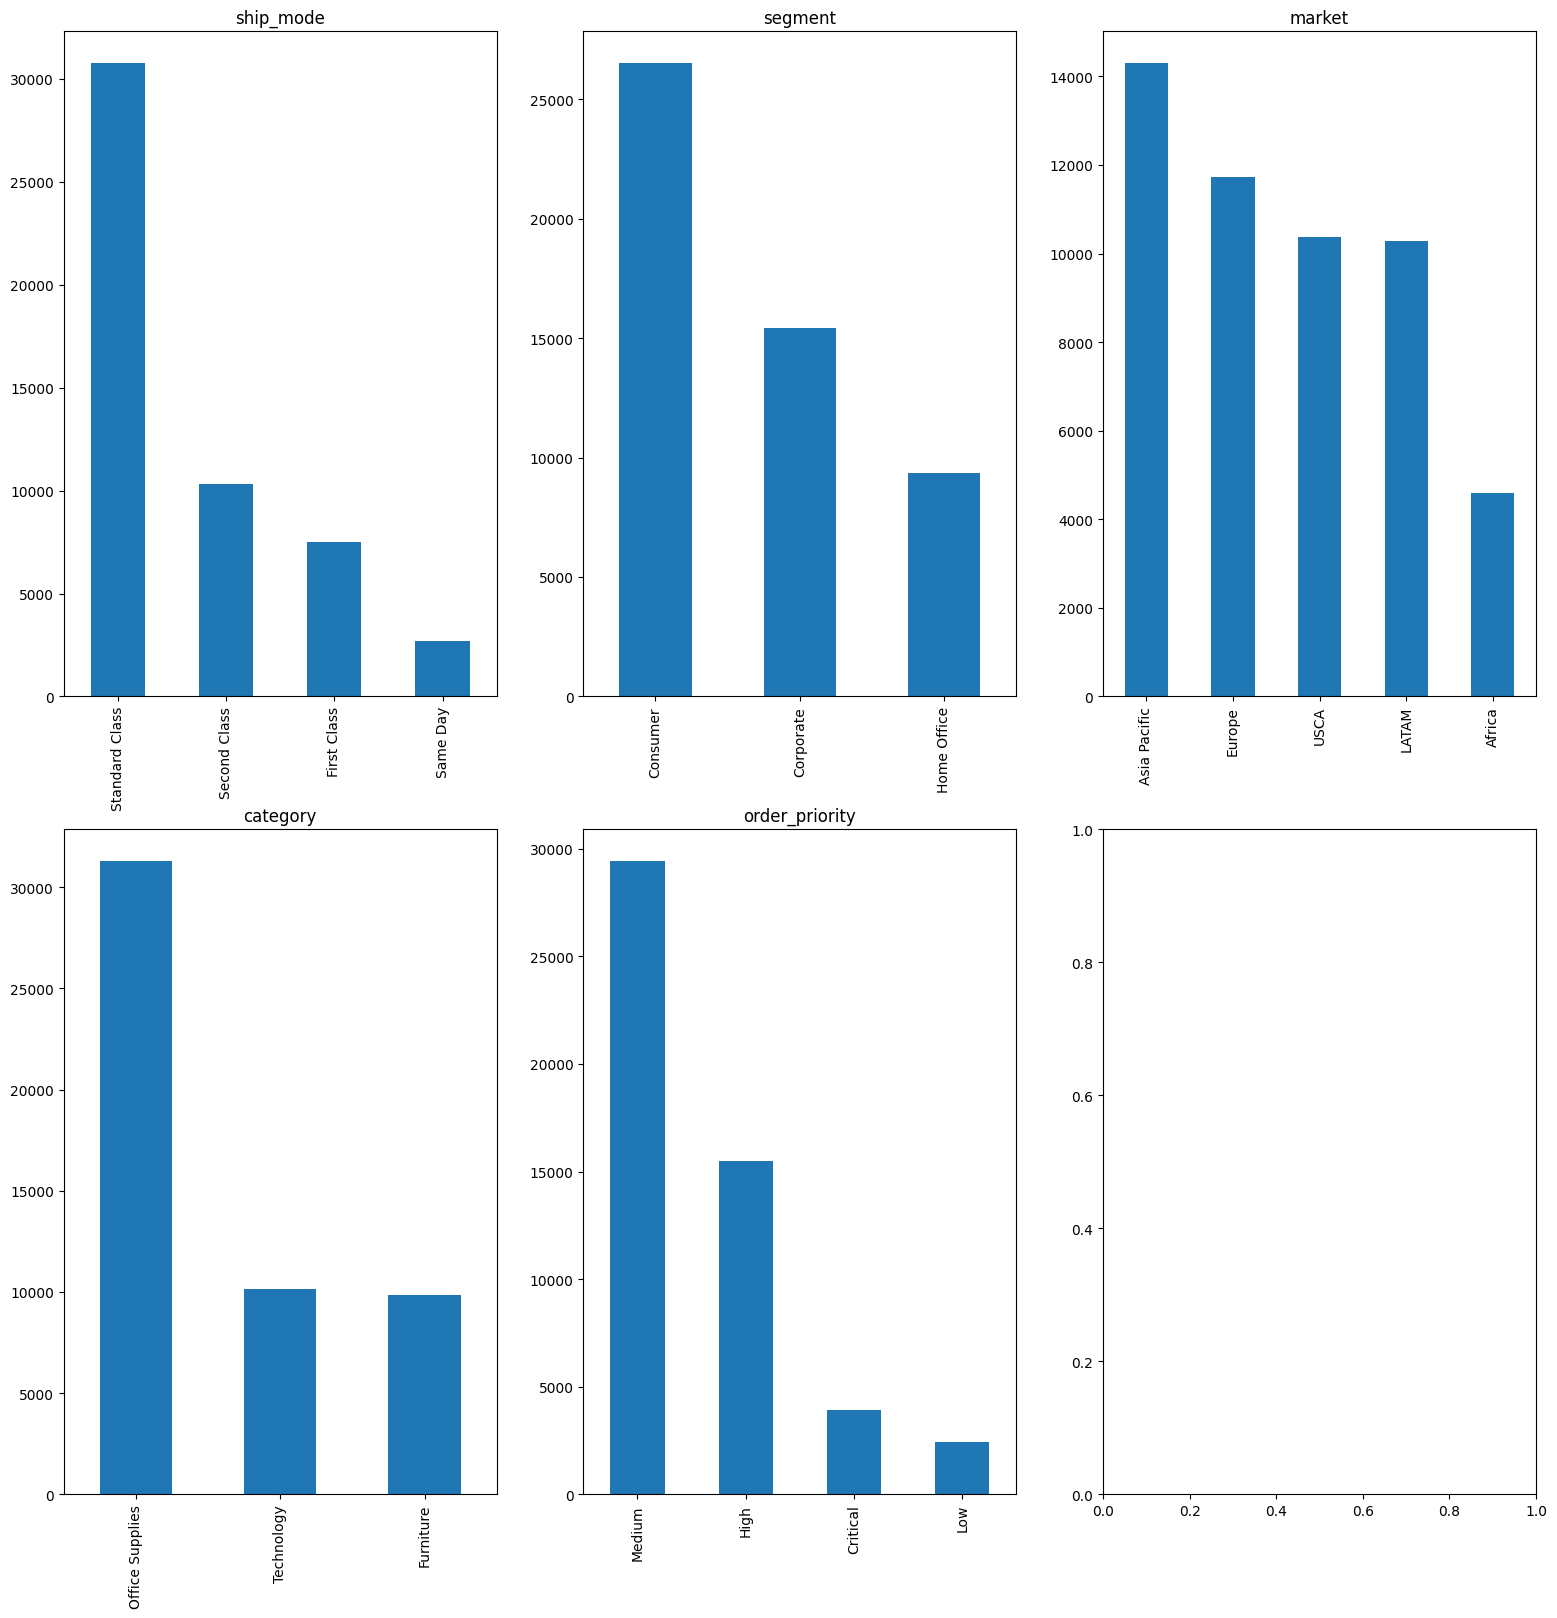

In [ ]:
# Visualization for categorical feature
ROWS, COLS = 2,3
fig, ax = plt.subplots(ROWS,COLS, figsize=(19,19))
row, col = 0, 0,
for i, categorical_feature in enumerate(categorical_features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    data[categorical_feature].value_counts().plot(kind='bar', ax=ax[row, col]).set_title(categorical_feature)

### **Date time Feature**

In this project, the datetime feature is order_date and ship_date, corresponding to purchase date and delivery date.

It can be assumed that items with a large difference between the order date and the ship date will result in returns.

Therefore, from order_date and ship_date will generate a new feature called ***date_diff***: **the difference between order_date and ship_date**

In [ ]:
data['date_diff'] = (data['ship_date'] - data['order_date']).dt.days
date_feature= ['date_diff']

### **Numerical Feature**

The numerical feature will be selected from the Numeric data type columns.
- Delete unused fields such as: **row_id**
- date_diff is a numerical feature

In [ ]:
numerical_features= [ 'sales', 'quantity', 'discount', 'profit', 'shipping_cost','date_diff']

In [ ]:
# The skew score for each numeric feature
for col in numerical_features:
    print(col, data[col].skew())

sales 8.13808002122054
quantity 1.3603677307024207
discount 1.387774552133839
profit 4.157190924838342
shipping_cost 5.872862839544146
date_diff -0.43134791800928035


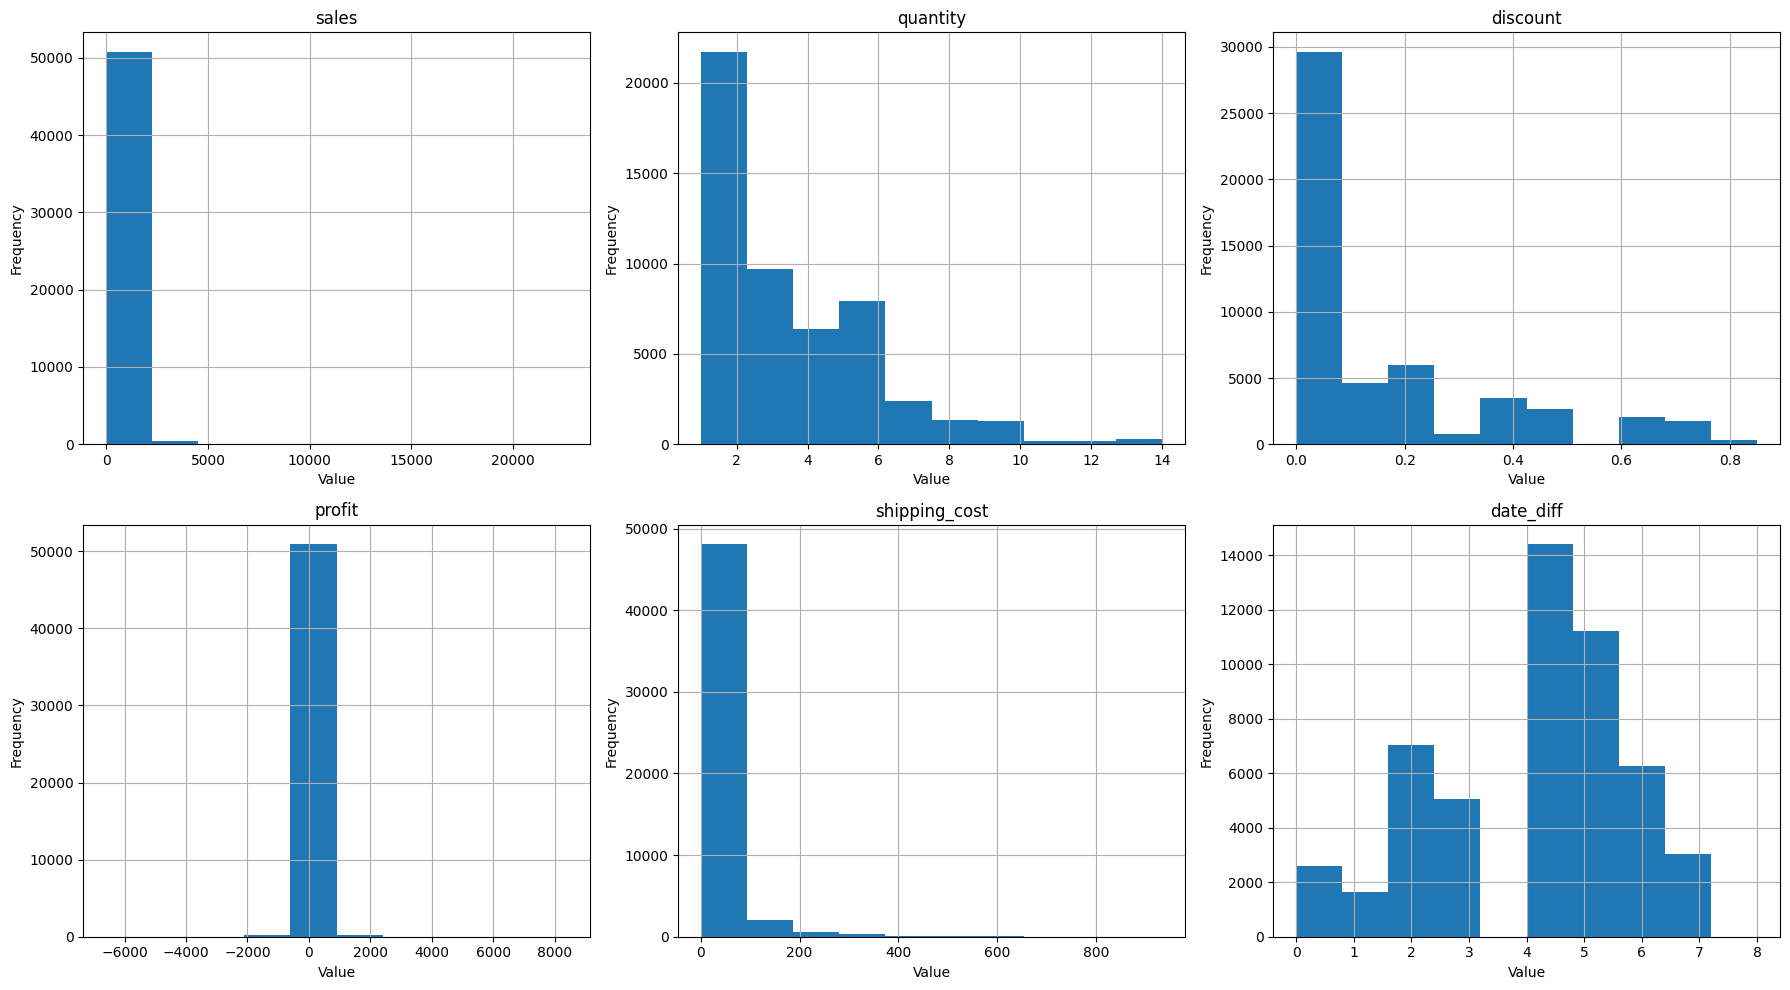

In [ ]:
# Distribution Visualization for numerical features
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

# Plot histograms for numerical features
for i, col in enumerate(numerical_features):
    ax = axes[i]
    data[col].hist(ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### **Target feature**



The target feature in this project is returned

In [ ]:
target_feature = "returned"

Text(0.5, 1.0, 'returned')

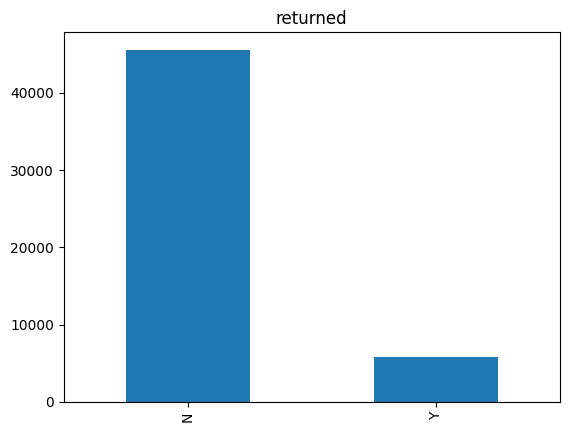

In [ ]:
data[target_feature].value_counts().plot(kind='bar').set_title('returned')


**Note: As we see, this is a imbalance data case.**

## **Outlier Detection for numerical feature**

In [ ]:
def count_outliers(data, col):
    q1 = data[col].quantile(0.25, interpolation='nearest')
    q3 = data[col].quantile(0.75, interpolation='nearest')
    IQR = q3 - q1
    LLP = q1 - 1.5 * IQR
    ULP = q3 + 1.5 * IQR

    lower_outliers = data[data[col] < LLP][col].size
    upper_outliers = data[data[col] > ULP][col].size

    if lower_outliers == 0 and upper_outliers == 0:
        print("No outliers in", col)
    else:
        print("There are outliers in", col)
        print('Count of lower outliers:', lower_outliers)
        print('Count of upper outliers:', upper_outliers)

numerical_features = ['sales', 'quantity', 'discount', 'profit', 'shipping_cost', 'date_diff']

for feature in numerical_features:
    count_outliers(data, feature)

There are outliers in sales
Count of lower outliers: 0
Count of upper outliers: 5655
There are outliers in quantity
Count of lower outliers: 0
Count of upper outliers: 877
There are outliers in discount
Count of lower outliers: 0
Count of upper outliers: 4172
There are outliers in profit
Count of lower outliers: 3526
Count of upper outliers: 6229
There are outliers in shipping_cost
Count of lower outliers: 0
Count of upper outliers: 5909
No outliers in date_diff


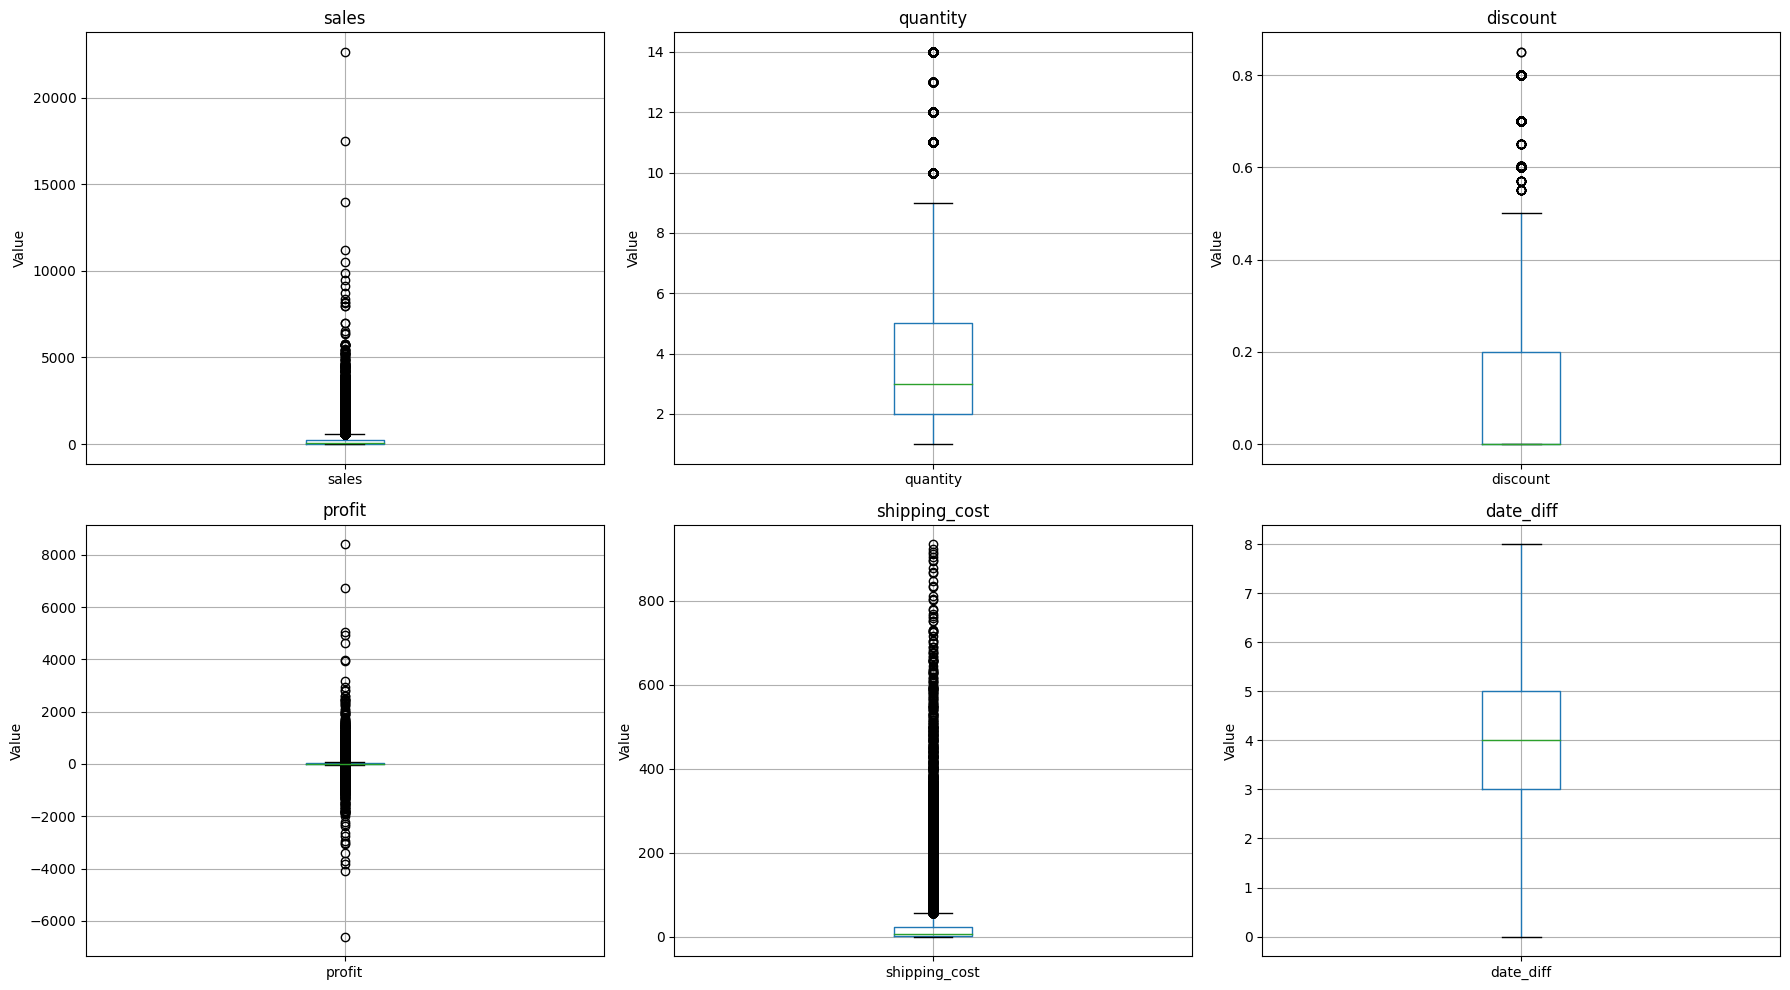

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

# Plot box plots for numerical features
for i, col in enumerate(numerical_features):
    ax = axes[i]
    data.boxplot(column=[col], ax=ax)
    ax.set_title(col)
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

There are lots of outlier in numerical feature. ***So it is necessary to tranform!***

## **Transformation for numerical features**

In [ ]:
data_transformed = data[numerical_features]
data_transformed.head()

,sales,quantity,discount,profit,shipping_cost,date_diff
0,13.08,3,0.0,4.56,2.03,4
1,252.16,8,0.0,90.72,13.45,5
2,193.28,2,0.0,54.08,9.63,5
3,35.44,4,0.0,4.96,1.37,5
4,71.60,2,0.0,11.44,3.79,5


### **With log transfomation**

In [ ]:
# Log-Transform
log_transform_features = ['sales', 'quantity', 'discount', 'profit', 'shipping_cost','date_diff']
for feature in log_transform_features:
    data_transformed[feature] = np.log1p(data_transformed[feature])

<ipython-input-24-1574a4e1e366>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_transformed[feature] = np.log1p(data_transformed[feature])
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


There are outliers in sales
Count of lower outliers: 0
Count of upper outliers: 28
No outliers in quantity
There are outliers in discount
Count of lower outliers: 0
Count of upper outliers: 4150
There are outliers in profit
Count of lower outliers: 130
Count of upper outliers: 81
There are outliers in shipping_cost
Count of lower outliers: 0
Count of upper outliers: 148
There are outliers in date_diff
Count of lower outliers: 4259
Count of upper outliers: 0


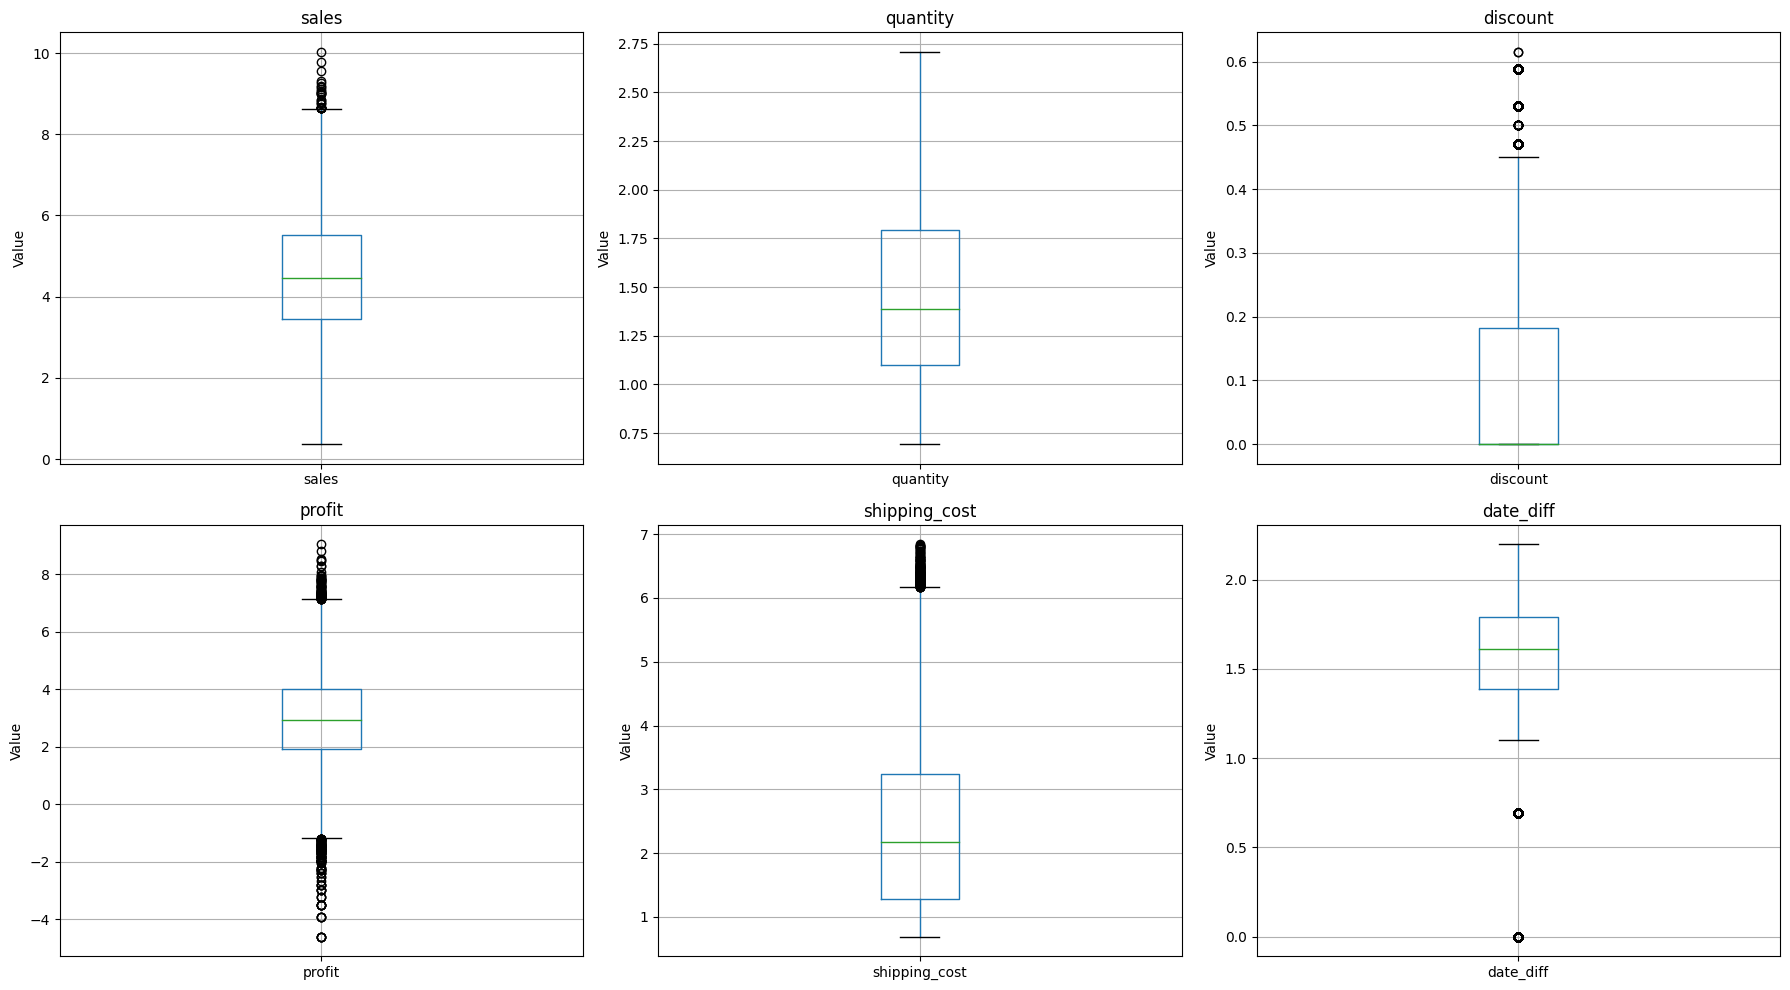

In [ ]:
# check oulier
for feature in log_transform_features:
    count_outliers(data_transformed, feature)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

# Plot box plots for numerical features
for i, col in enumerate(log_transform_features):
    ax = axes[i]
    data_transformed.boxplot(column=[col], ax=ax)
    ax.set_title(col)
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

In [ ]:
# Log-Transform
log_transform_features = ['sales', 'quantity', 'discount', 'profit', 'shipping_cost','date_diff']
for feature in log_transform_features:
    data_transformed[f'{feature}_log'] = np.log1p(data_transformed[feature])
data_transformed.drop(log_transform_features, axis=1, inplace=True)



<ipython-input-26-00fa979a0c2b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_transformed[f'{feature}_log'] = np.log1p(data_transformed[feature])
<ipython-input-26-00fa979a0c2b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_transformed[f'{feature}_log'] = np.log1p(data_transformed[feature])
<ipython-input-26-00fa979a0c2b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [ ]:
data_transformed

,sales_log,quantity_log,discount_log,profit_log,shipping_cost_log,date_diff_log
0,1.293289,0.869742,0.0,0.999012,0.746006,0.959135
1,1.877023,1.162283,0.0,1.708150,1.300381,1.026672
2,1.835665,0.741276,0.0,1.611194,1.213036,1.026672
3,1.525114,0.959135,0.0,1.024273,0.622129,1.026672
4,1.664866,0.741276,0.0,1.258721,0.942555,1.026672
...,...,...,...,...,...,...
51285,1.250109,0.526589,0.0,0.910731,0.738084,0.741276
51286,1.635925,0.741276,0.0,1.377835,1.292117,0.741276
51287,1.686556,0.959135,0.0,1.407462,1.187947,0.741276
51288,1.771310,0.959135,0.0,1.515296,1.384851,0.741276


## **Encoder for Categorical feature**

### **Check unique value of categorical feature**

In [ ]:
for feature in categorical_features:
    print(feature,data[feature].nunique())

ship_mode 4
segment 3
market 5
category 3
order_priority 4


### **One hot Encoding for categorical and target feature**

In [ ]:
categorical_dummies = pd.get_dummies(data[categorical_features], drop_first=True)
target_dummy = pd.get_dummies(data['returned'], drop_first=True)

## **Final Dataset**

### **Concat to datafinal**

In [ ]:
datafinal = pd.concat([categorical_dummies , data_transformed,target_dummy], axis=1)

In [ ]:
datafinal.columns

Index(['ship_mode_Same Day', 'ship_mode_Second Class',
       'ship_mode_Standard Class', 'segment_Corporate', 'segment_Home Office',
       'market_Asia Pacific', 'market_Europe', 'market_LATAM', 'market_USCA',
       'category_Office Supplies', 'category_Technology',
       'order_priority_High', 'order_priority_Low', 'order_priority_Medium',
       'sales_log', 'quantity_log', 'discount_log', 'profit_log',
       'shipping_cost_log', 'date_diff_log', 'Y'],
      dtype='object')

### **View Correlation**

In [ ]:

# View correlation
corr = datafinal.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-32-06caf9e96b5c>:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,ship_mode_Same Day,ship_mode_Second Class,ship_mode_Standard Class,segment_Corporate,segment_Home Office,market_Asia Pacific,market_Europe,market_LATAM,market_USCA,category_Office Supplies,category_Technology,order_priority_High,order_priority_Low,order_priority_Medium,sales_log,quantity_log,discount_log,profit_log,shipping_cost_log,date_diff_log,Y
ship_mode_Same Day,1.00,-0.12,-0.29,-0.02,0.00,-0.01,0.00,-0.00,0.01,0.01,-0.00,0.09,-0.05,-0.15,-0.00,-0.01,0.00,-0.00,0.07,-0.84,0.01
ship_mode_Second Class,-0.12,1.00,-0.61,0.01,-0.00,-0.00,-0.01,0.00,-0.01,0.00,-0.00,0.09,-0.11,-0.11,0.00,-0.01,-0.01,-0.01,0.05,-0.05,-0.00
ship_mode_Standard Class,-0.29,-0.61,1.00,0.00,0.00,0.01,0.00,0.00,-0.01,-0.01,0.00,-0.22,0.18,0.31,0.00,0.01,-0.00,0.01,-0.16,0.61,-0.00
segment_Corporate,-0.02,0.01,0.00,1.00,-0.31,0.00,0.01,-0.00,0.00,-0.00,0.00,-0.02,0.00,0.02,0.00,-0.00,0.00,0.00,0.00,0.02,-0.00
segment_Home Office,0.00,-0.00,0.00,-0.31,1.00,0.00,-0.01,0.01,-0.00,0.01,-0.00,-0.00,0.02,-0.00,-0.00,-0.00,-0.01,0.00,-0.00,-0.00,0.00
market_Asia Pacific,-0.01,-0.00,0.01,0.00,0.00,1.00,-0.34,-0.31,-0.31,-0.03,0.02,0.00,-0.01,0.01,0.07,-0.03,0.12,0.05,0.06,0.00,0.00
market_Europe,0.00,-0.01,0.00,0.01,-0.01,-0.34,1.00,-0.27,-0.27,0.05,-0.01,-0.01,0.02,0.00,0.12,0.03,-0.14,0.05,0.10,0.00,-0.01
market_LATAM,-0.00,0.00,0.00,-0.00,0.01,-0.31,-0.27,1.00,-0.25,-0.04,0.00,0.00,0.01,-0.00,0.00,0.09,-0.01,-0.04,-0.01,0.01,-0.01
market_USCA,0.01,-0.01,-0.01,0.00,-0.00,-0.31,-0.27,-0.25,1.00,-0.00,-0.02,0.01,-0.01,-0.00,-0.15,0.08,0.03,-0.04,-0.11,-0.01,0.01
category_Office Supplies,0.01,0.00,-0.01,-0.00,0.01,-0.03,0.05,-0.04,-0.00,1.00,-0.62,0.00,0.00,-0.01,-0.50,-0.02,-0.05,-0.34,-0.48,-0.01,0.00


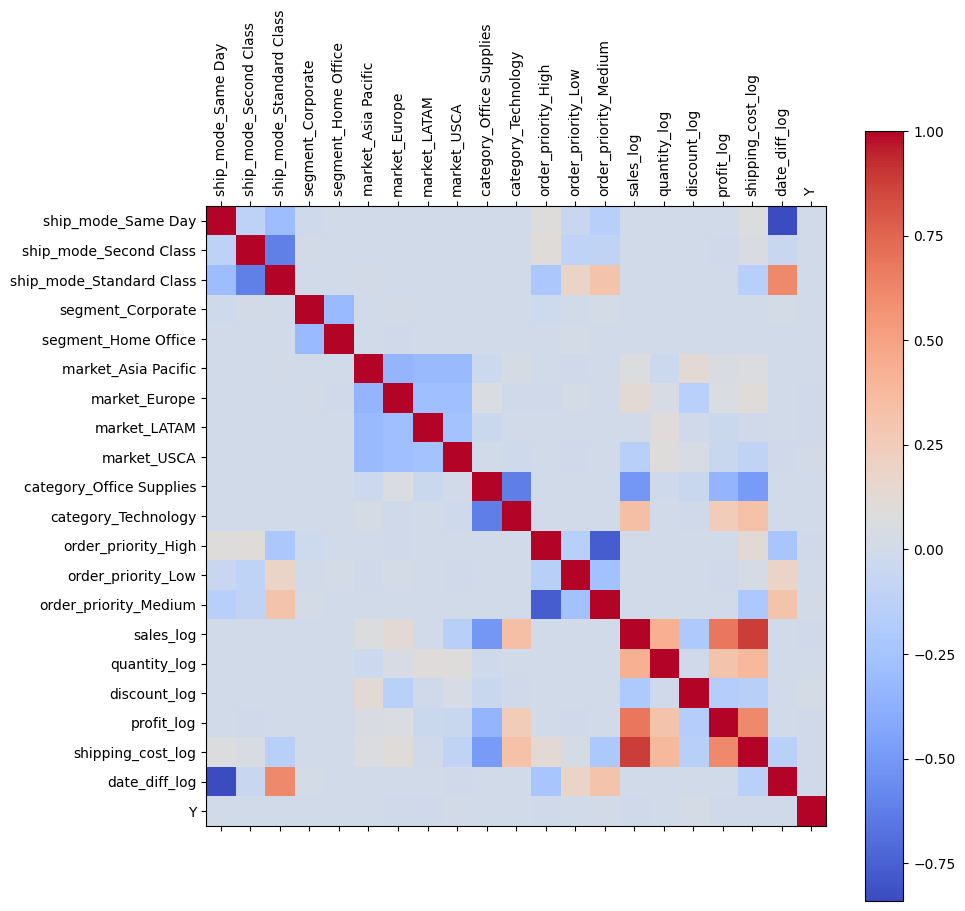

In [ ]:
# Calculate correlation matrix
corr = datafinal.corr()

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Create a heatmap
cax = ax.matshow(corr, cmap='coolwarm')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar(cax)

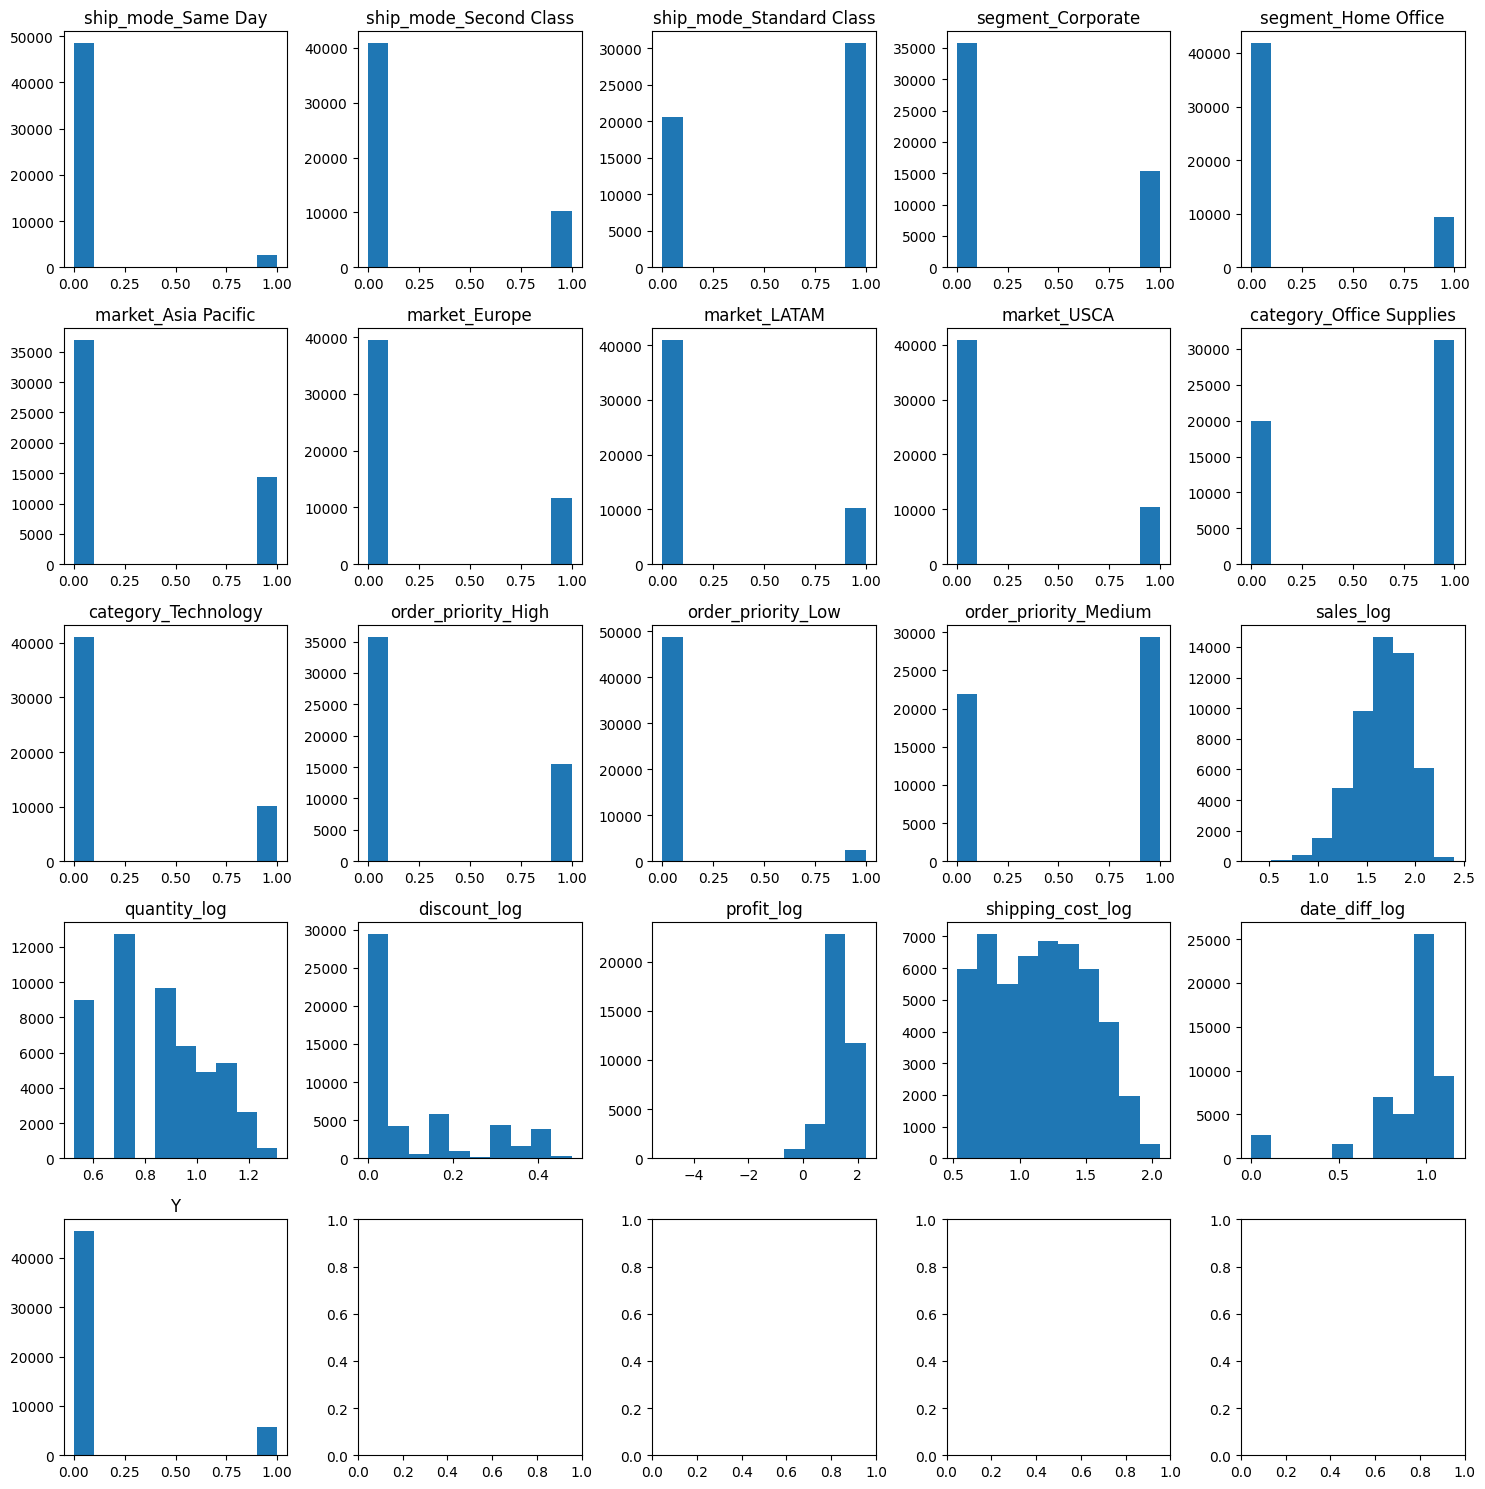

In [ ]:
# Distribution Visualization for all features
num_rows = 5
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

features = datafinal.columns
counter = 0

for row in range(num_rows):
    for col in range(num_cols):
        if counter < len(features):
            axes[row, col].hist(datafinal[features[counter]])
            axes[row, col].set_title(features[counter])
            counter += 1

plt.tight_layout()
plt.show()

## **Training Model**

In [ ]:
datafinal.isnull().sum()

ship_mode_Same Day              0
ship_mode_Second Class          0
ship_mode_Standard Class        0
segment_Corporate               0
segment_Home Office             0
market_Asia Pacific             0
market_Europe                   0
market_LATAM                    0
market_USCA                     0
category_Office Supplies        0
category_Technology             0
order_priority_High             0
order_priority_Low              0
order_priority_Medium           0
sales_log                       0
quantity_log                    0
discount_log                    0
profit_log                  12180
shipping_cost_log               0
date_diff_log                   0
Y                               0
dtype: int64

### **Split to Train and Test**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
# Feature selection
X = datafinal.drop(["Y",'profit_log'], axis=1)
y = datafinal['Y']

# Split train ,test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Upsampling with SMOTE and Min max Scaler**

In [ ]:
# Upsampling with SMOTE
sm = SMOTE(k_neighbors=5)
X_train_resample, y_train_resample = sm.fit_resample(X_train, y_train)

from sklearn.preprocessing import MinMaxScaler
# Scaling with Min-Max Scaler
numeric_columns = ['sales_log', 'quantity_log', 'discount_log',
       'shipping_cost_log', 'date_diff_log']
scaler = MinMaxScaler()
scaler.fit(X_train_resample[numeric_columns])
X_train_resample[numeric_columns] = scaler.transform(X_train_resample[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

### **XGBoost**


XGBoost Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      9109
           1       0.20      0.02      0.04      1149

    accuracy                           0.88     10258
   macro avg       0.54      0.50      0.49     10258
weighted avg       0.81      0.88      0.84     10258

Accuracy on Train: 0.92
Accuracy on Test: 0.88


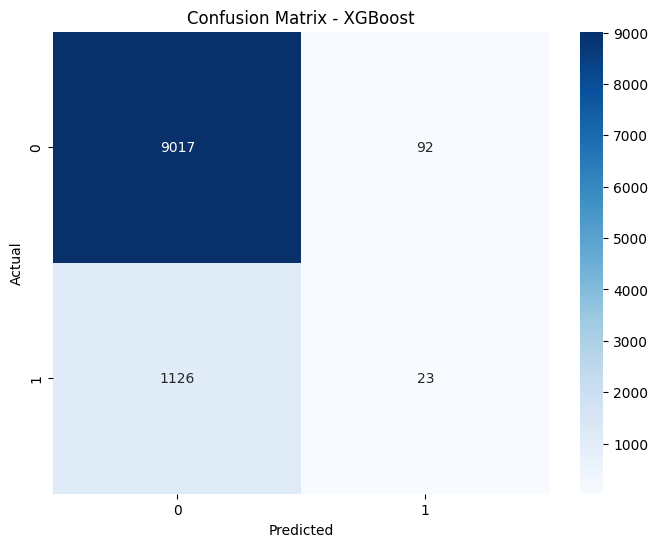

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model_xgb = xgb.XGBClassifier(random_state=42, n_estimators=200)
model_xgb.fit(X_train_resample, y_train_resample)
y_pred_xgb = model_xgb.predict(X_test)

# Result
print("XGBoost Report:")
print(classification_report(y_test, y_pred_xgb))

# Accuracy on Train and Test
accuracy_train_xgb = model_xgb.score(X_train_resample, y_train_resample)
accuracy_test_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy on Train: {accuracy_train_xgb:.2f}")
print(f"Accuracy on Test: {accuracy_test_xgb:.2f}")

# Confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()




### **Random Forest Classifier**

Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      9109
           1       0.17      0.09      0.11      1149

    accuracy                           0.85     10258
   macro avg       0.53      0.52      0.52     10258
weighted avg       0.81      0.85      0.83     10258

Accuracy on Train: 1.00
Accuracy on Test: 0.85


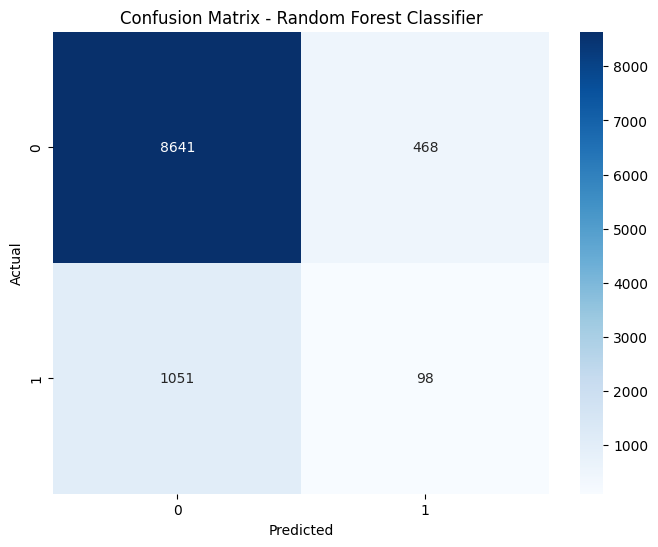

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model_rfc = RandomForestClassifier(random_state=42, n_estimators=200)
model_rfc.fit(X_train_resample, y_train_resample)
y_pred_rfc = model_rfc.predict(X_test)

# Result
print("Random Forest Classifier Report:")
print(classification_report(y_test, y_pred_rfc))

# Accuracy on Train and Test
accuracy_train_rfc = model_rfc.score(X_train_resample, y_train_resample)
accuracy_test_rfc = accuracy_score(y_test, y_pred_rfc)
print(f"Accuracy on Train: {accuracy_train_rfc:.2f}")
print(f"Accuracy on Test: {accuracy_test_rfc:.2f}")

# Confusion matrix
conf_matrix_rfc = confusion_matrix(y_test, y_pred_rfc)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rfc, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()




### **Support Vector Classifier**

Classification Report for Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.90      0.57      0.70      9109
           1       0.13      0.50      0.20      1149

    accuracy                           0.56     10258
   macro avg       0.51      0.53      0.45     10258
weighted avg       0.81      0.56      0.64     10258

Accuracy on train set: 0.6302
Accuracy on test set: 0.5639


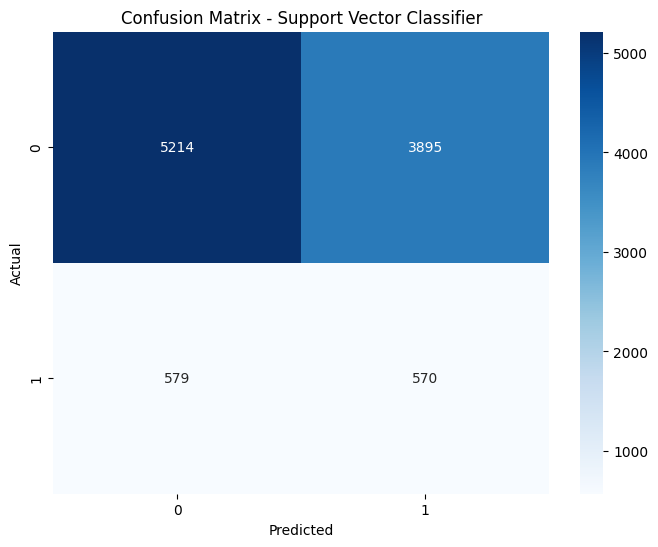

In [ ]:
from sklearn.svm import SVC

# Create and train Support Vector Classifier model
model_svc = SVC(random_state=42)
model_svc.fit(X_train_resample, y_train_resample)

# Predict on test set
y_pred_svc = model_svc.predict(X_test)

# Print classification report
print("Classification Report for Support Vector Classifier:")
print(classification_report(y_test, y_pred_svc))

# Compute and print accuracy for train and test
accuracy_train_svc = model_svc.score(X_train_resample, y_train_resample)
accuracy_test_svc = accuracy_score(y_test, y_pred_svc)
print(f"Accuracy on train set: {accuracy_train_svc:.4f}")
print(f"Accuracy on test set: {accuracy_test_svc:.4f}")

# Compute and plot confusion matrix
conf_matrix_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svc, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Support Vector Classifier')
plt.show()

## **Model Evalutation**

In [ ]:
from sklearn.metrics import f1_score
import pandas as pd

# List of models
models = [model_xgb, model_rfc, model_svc]

# List of model names
model_names = ['XGBoost', 'Random Forest', 'Support Vector Classifier']

# Calculate evaluation metrics for each model
accuracy = [model.score(X_test, y_test) for model in models]
train_accuracy = [model.score(X_train, y_train) for model in models]
f1_scores = [f1_score(y_test, model.predict(X_test)) for model in models]

# Create a dictionary to store evaluation metrics
evaluation_metrics = {
    'Model': model_names,
    'Accuracy': accuracy,
    'Train Accuracy': train_accuracy,
    'F1 Score': f1_scores
}

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(evaluation_metrics)

# Print the DataFrame
print(metrics_df)

# Find the model with the highest accuracy and F1-score
best_accuracy_model = metrics_df.loc[metrics_df['Accuracy'].idxmax(), 'Model']
best_f1_model = metrics_df.loc[metrics_df['F1 Score'].idxmax(), 'Model']



                       Model  Accuracy  Train Accuracy  F1 Score
0                    XGBoost  0.881263        0.218585  0.036392
1              Random Forest  0.851920        0.763234  0.114286
2  Support Vector Classifier  0.563853        0.868127  0.203064


## **Save model**

In [ ]:
import joblib

# Save the model to a file
model_rfc_filename = '/content/drive/MyDrive/PROJECTS/Project: SuperstoreSales/rfc_model.pkl'
joblib.dump(model_rfc, model_rfc_filename)

# Load the model from the file
loaded_model_rfc = joblib.load(model_rfc_filename)